# MASTER THESIS - ENSEMBLE

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Import-Files" data-toc-modified-id="Import-Files-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Import Files</a></span></li><li><span><a href="#Headers" data-toc-modified-id="Headers-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Headers</a></span></li></ul></li><li><span><a href="#Custom-Functions" data-toc-modified-id="Custom-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Custom Functions</a></span></li><li><span><a href="#Model-Preparation" data-toc-modified-id="Model-Preparation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Preparation</a></span><ul class="toc-item"><li><span><a href="#Actuals" data-toc-modified-id="Actuals-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Actuals</a></span></li><li><span><a href="#Differences-&amp;-Lags" data-toc-modified-id="Differences-&amp;-Lags-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Differences &amp; Lags</a></span></li><li><span><a href="#Train-&amp;-Test" data-toc-modified-id="Train-&amp;-Test-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Train &amp; Test</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Back-Transformation" data-toc-modified-id="Back-Transformation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Back-Transformation</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Numerical" data-toc-modified-id="Numerical-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Numerical</a></span></li><li><span><a href="#Visual" data-toc-modified-id="Visual-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Visual</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Visualization</a></span></li></ul></div>

### Parameters
***

In [1]:
# Specify input data --------------------------------------------------------------------------
freq_all = ["day","week","month"]
freq = freq_all[0]


# Prediction ----------------------------------------------------------------------------------
pred_start = "2018-01-01"
steps = 5
lag = 90

target_all = ["original","delta"]
target = target_all[0]

In [2]:
print (f' Yield curve data frequency is {freq}-wise.')
print (f' The random forest regressor has {lag} lags.')
print (f' The prediction is made for {pred_start} until {steps} {freq}s into the future.')
print (f' The target variable is PC-{target}.')

 Yield curve data frequency is day-wise.
 The random forest regressor has 90 lags.
 The prediction is made for 2018-01-01 until 5 days into the future.
 The target variable is PC-original.


### Import
***

#### Import Packages

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [4]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.6f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
# Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from xgboost import XGBRegressor

In [6]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.pyplot import cm
import seaborn as sns

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')
days_fmt = mdates.DateFormatter('%Y-%m-%d')

%config InlineBackend.figure_format ="retina"

In [7]:
import sys, os
def blockPrint(): sys.stdout = open(os.devnull, 'w')
def enablePrint(): sys.stdout = sys.__stdout__ 
# blockPrint()

#### Import Files

In [8]:
# Filepaths -------------------------------------------------------------------------------------------
filepath_spot = "C:/Users/bernh/Jupyter scripts/04 Master Thesis/Data/02_cleaned/"
filepath_pca  = "C:/Users/bernh/Jupyter scripts/04 Master Thesis/Data/03_pca/"

# Filenames -------------------------------------------------------------------------------------------
filename_W_k = "W_k_inv_" + str(freq)+".csv"
filename_T_k = "T_k_" + str(freq)+".csv"
filename_X_k = "X_k_" + str(freq)+".csv"
filename_spot = "spot_"+ str(freq)+".csv"

In [9]:
# PC-loadings -----------------------------------------------------------------------------------------
W_k_inv = pd.read_csv(filepath_pca + filename_W_k, index_col = 0)
W_k_inv.columns.name = "W_k_inv_" + str(freq)

# PC-scores -------------------------------------------------------------------------------------------
T_k = pd.read_csv(filepath_pca + filename_T_k, index_col = 0)
T_k.columns.name = "T_k_" + str(freq)
T_k.index = pd.to_datetime(T_k.index)

# Model spot rates ------------------------------------------------------------------------------------
X_k = pd.read_csv(filepath_pca + filename_X_k, index_col = 0)
X_k.columns.name = "X_k_" + str(freq)
X_k.index = pd.to_datetime(X_k.index)

# Actual spot rates -----------------------------------------------------------------------------------
spot = pd.read_csv(filepath_spot + filename_spot, index_col = 0)
spot.columns.name = "Act_spot_" + str(freq)
spot.index = pd.to_datetime(spot.index)

#### Headers

In [10]:
cols = W_k_inv.T.columns
cols_diff = cols+"_diff"
cols_cum = cols+"_cum"
cols_frac = cols+"_frac"
cols_len = len(cols)

### Custom Functions
***

In [11]:
def fast_fracdiff(x, d):
    import pylab as pl
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T) 
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    
    return np.real(dx[0:T])

### Model Preparation
***

#### Actuals

In [12]:
spot_train = spot[spot.index < pred_start]
spot_test = spot[spot.index >= pred_start]

In [13]:
# Actual yields in train
spot_train.tail()

Act_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2017-12-21,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2017-12-22,-0.826033,-0.813788,-0.777337,-0.664987,-0.517400,-0.353124,-0.185911,-0.024712,0.125365,0.261937,0.384398,0.493208,0.674254,0.815247,0.925918,1.014033,1.085353,1.144038,1.193075,1.234619,1.270249,1.301137
2017-12-27,-0.845695,-0.825995,-0.782740,-0.673152,-0.534009,-0.376399,-0.212622,-0.052185,0.098842,0.237252,0.361877,0.472845,0.657611,0.801348,0.913972,1.003493,1.075865,1.135370,1.185069,1.227164,1.263262,1.294552
2017-12-28,-0.748190,-0.746003,-0.726626,-0.637618,-0.502549,-0.344070,-0.178989,-0.018215,0.132025,0.268784,0.391224,0.499750,0.679580,0.818893,0.927803,1.014273,1.084139,1.141569,1.189529,1.230149,1.264981,1.295173
2017-12-29,-0.780057,-0.769592,-0.737874,-0.635217,-0.494164,-0.332811,-0.165891,-0.003460,0.148531,0.287169,0.411562,0.522043,0.705575,0.848121,0.959744,1.048458,1.120177,1.179148,1.228403,1.270123,1.305900,1.336912


In [14]:
# Actual yields in test
spot_test.head()

Act_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.745998,-0.738445,-0.712228,-0.618449,-0.483050,-0.324544,-0.158394,0.004649,0.158085,0.298607,0.425060,0.537615,0.725001,0.870810,0.985105,1.075991,1.149487,1.209929,1.260415,1.303180,1.339852,1.371642
2018-01-03,-0.689726,-0.699190,-0.696930,-0.625850,-0.496899,-0.339074,-0.172192,-0.008581,0.144852,0.284841,0.410392,0.521837,0.706840,0.850445,0.962874,1.052225,1.124464,1.183865,1.233482,1.275510,1.311551,1.342792
2018-01-04,-0.664711,-0.677090,-0.678375,-0.609208,-0.479648,-0.321098,-0.154146,0.008797,0.160989,0.299369,0.423126,0.532726,0.714207,0.854750,0.964630,1.051888,1.122404,1.180376,1.228794,1.269804,1.304971,1.335455
2018-01-05,-0.659469,-0.672334,-0.675266,-0.610466,-0.484993,-0.329451,-0.164337,-0.002245,0.149828,0.288587,0.413031,0.523487,0.706836,0.849153,0.960575,1.049129,1.120726,1.179601,1.228778,1.270434,1.306157,1.337122
2018-01-08,-0.646781,-0.664524,-0.675209,-0.620244,-0.499954,-0.346989,-0.182959,-0.021089,0.131257,0.270563,0.395694,0.506896,0.691724,0.835372,0.947927,1.037427,1.109810,1.169342,1.219072,1.261199,1.297326,1.328643


#### Differences & Lags

In [15]:
# Add lags to absolute components ---------------------------------------------------------
if target == "original":
    for i in cols:
        for j in range(steps, steps + lag + 1):
            T_k[i+"_lag_"+str(j)] = T_k[i].shift(j)  
        

if target == "delta":
    # Add differences to delta components -------------------------------------------------
    for i in cols:
        T_k[i+"_diff"] = T_k[i].diff()
        
    for i in cols:
        T_k[i+"_frac"] = fast_fracdiff(x = T_k[i], d=0.35)

    # Add lags to delta components --------------------------------------------------------        
    for i in cols_diff:
        for j in range(steps, steps + lag + 1):
            T_k[i+"_lag_"+str(j)] = T_k[i].shift(j)
            
    for i in cols_frac:
        for j in range(steps, steps + lag + 1):
            T_k[i+"_lag_"+str(j)] = T_k[i].shift(j)
            
    for i in cols:
        T_k = T_k.drop(i, axis = 1)


# Print -----------------------------------------------------------------------------------
T_k = T_k.iloc[steps + lag + 1:]
T_k.tail(10)

T_k_day,PC_1,PC_2,PC_3,PC_4,PC_5,PC_1_lag_5,PC_1_lag_6,PC_1_lag_7,PC_1_lag_8,PC_1_lag_9,PC_1_lag_10,PC_1_lag_11,PC_1_lag_12,PC_1_lag_13,PC_1_lag_14,PC_1_lag_15,PC_1_lag_16,PC_1_lag_17,PC_1_lag_18,PC_1_lag_19,PC_1_lag_20,PC_1_lag_21,PC_1_lag_22,PC_1_lag_23,PC_1_lag_24,PC_1_lag_25,PC_1_lag_26,PC_1_lag_27,PC_1_lag_28,PC_1_lag_29,PC_1_lag_30,PC_1_lag_31,PC_1_lag_32,PC_1_lag_33,PC_1_lag_34,PC_1_lag_35,PC_1_lag_36,PC_1_lag_37,PC_1_lag_38,PC_1_lag_39,PC_1_lag_40,PC_1_lag_41,PC_1_lag_42,PC_1_lag_43,PC_1_lag_44,PC_1_lag_45,PC_1_lag_46,PC_1_lag_47,PC_1_lag_48,PC_1_lag_49,PC_1_lag_50,PC_1_lag_51,PC_1_lag_52,PC_1_lag_53,PC_1_lag_54,PC_1_lag_55,PC_1_lag_56,PC_1_lag_57,PC_1_lag_58,PC_1_lag_59,PC_1_lag_60,PC_1_lag_61,PC_1_lag_62,PC_1_lag_63,PC_1_lag_64,PC_1_lag_65,PC_1_lag_66,PC_1_lag_67,PC_1_lag_68,PC_1_lag_69,PC_1_lag_70,PC_1_lag_71,PC_1_lag_72,PC_1_lag_73,PC_1_lag_74,PC_1_lag_75,PC_1_lag_76,PC_1_lag_77,PC_1_lag_78,PC_1_lag_79,PC_1_lag_80,PC_1_lag_81,PC_1_lag_82,PC_1_lag_83,PC_1_lag_84,PC_1_lag_85,PC_1_lag_86,PC_1_lag_87,PC_1_lag_88,PC_1_lag_89,PC_1_lag_90,PC_1_lag_91,PC_1_lag_92,PC_1_lag_93,PC_1_lag_94,PC_1_lag_95,PC_2_lag_5,PC_2_lag_6,PC_2_lag_7,PC_2_lag_8,PC_2_lag_9,PC_2_lag_10,PC_2_lag_11,PC_2_lag_12,PC_2_lag_13,PC_2_lag_14,PC_2_lag_15,PC_2_lag_16,PC_2_lag_17,PC_2_lag_18,PC_2_lag_19,PC_2_lag_20,PC_2_lag_21,PC_2_lag_22,PC_2_lag_23,PC_2_lag_24,PC_2_lag_25,PC_2_lag_26,PC_2_lag_27,PC_2_lag_28,PC_2_lag_29,PC_2_lag_30,PC_2_lag_31,PC_2_lag_32,PC_2_lag_33,PC_2_lag_34,PC_2_lag_35,PC_2_lag_36,PC_2_lag_37,PC_2_lag_38,PC_2_lag_39,PC_2_lag_40,PC_2_lag_41,PC_2_lag_42,PC_2_lag_43,PC_2_lag_44,PC_2_lag_45,PC_2_lag_46,PC_2_lag_47,PC_2_lag_48,PC_2_lag_49,PC_2_lag_50,PC_2_lag_51,PC_2_lag_52,PC_2_lag_53,PC_2_lag_54,PC_2_lag_55,PC_2_lag_56,PC_2_lag_57,PC_2_lag_58,PC_2_lag_59,PC_2_lag_60,PC_2_lag_61,PC_2_lag_62,PC_2_lag_63,PC_2_lag_64,PC_2_lag_65,PC_2_lag_66,PC_2_lag_67,PC_2_lag_68,PC_2_lag_69,PC_2_lag_70,PC_2_lag_71,PC_2_lag_72,PC_2_lag_73,PC_2_lag_74,PC_2_lag_75,PC_2_lag_76,PC_2_lag_77,PC_2_lag_78,PC_2_lag_79,PC_2_lag_80,PC_2_lag_81,PC_2_lag_82,PC_2_lag_83,PC_2_lag_84,PC_2_lag_85,PC_2_lag_86,PC_2_lag_87,PC_2_lag_88,PC_2_lag_89,PC_2_lag_90,PC_2_lag_91,PC_2_lag_92,PC_2_lag_93,PC_2_lag_94,PC_2_lag_95,PC_3_lag_5,PC_3_lag_6,PC_3_lag_7,PC_3_lag_8,PC_3_lag_9,PC_3_lag_10,PC_3_lag_11,PC_3_lag_12,PC_3_lag_13,PC_3_lag_14,PC_3_lag_15,PC_3_lag_16,PC_3_lag_17,PC_3_lag_18,PC_3_lag_19,PC_3_lag_20,PC_3_lag_21,PC_3_lag_22,PC_3_lag_23,PC_3_lag_24,PC_3_lag_25,PC_3_lag_26,PC_3_lag_27,PC_3_lag_28,PC_3_lag_29,PC_3_lag_30,PC_3_lag_31,PC_3_lag_32,PC_3_lag_33,PC_3_lag_34,PC_3_lag_35,PC_3_lag_36,PC_3_lag_37,PC_3_lag_38,PC_3_lag_39,PC_3_lag_40,PC_3_lag_41,PC_3_lag_42,PC_3_lag_43,PC_3_lag_44,PC_3_lag_45,PC_3_lag_46,PC_3_lag_47,PC_3_lag_48,PC_3_lag_49,PC_3_lag_50,PC_3_lag_51,PC_3_lag_52,PC_3_lag_53,PC_3_lag_54,PC_3_lag_55,PC_3_lag_56,PC_3_lag_57,PC_3_lag_58,PC_3_lag_59,PC_3_lag_60,PC_3_lag_61,PC_3_lag_62,PC_3_lag_63,PC_3_lag_64,PC_3_lag_65,PC_3_lag_66,PC_3_lag_67,PC_3_lag_68,PC_3_lag_69,PC_3_lag_70,PC_3_lag_71,PC_3_lag_72,PC_3_lag_73,PC_3_lag_74,PC_3_lag_75,PC_3_lag_76,PC_3_lag_77,PC_3_lag_78,PC_3_lag_79,PC_3_lag_80,PC_3_lag_81,PC_3_lag_82,PC_3_lag_83,PC_3_lag_84,PC_3_lag_85,PC_3_lag_86,PC_3_lag_87,PC_3_lag_88,PC_3_lag_89,PC_3_lag_90,PC_3_lag_91,PC_3_lag_92,PC_3_lag_93,PC_3_lag_94,PC_3_lag_95,PC_4_lag_5,PC_4_lag_6,PC_4_lag_7,PC_4_lag_8,PC_4_lag_9,PC_4_lag_10,PC_4_lag_11,PC_4_lag_12,PC_4_lag_13,PC_4_lag_14,PC_4_lag_15,PC_4_lag_16,PC_4_lag_17,PC_4_lag_18,PC_4_lag_19,PC_4_lag_20,PC_4_lag_21,PC_4_lag_22,PC_4_lag_23,PC_4_lag_24,PC_4_lag_25,PC_4_lag_26,PC_4_lag_27,PC_4_lag_28,PC_4_lag_29,PC_4_lag_30,PC_4_lag_31,PC_4_lag_32,PC_4_lag_33,PC_4_lag_34,PC_4_lag_35,PC_4_lag_36,PC_4_lag_37,PC_4_lag_38,PC_4_lag_39,PC_4_lag_40,PC_4_lag_41,PC_4_lag_42,PC_4_lag_43,PC_4_lag_44,PC_4_lag_45,PC_4_lag_46,PC_4_lag_47,PC_4_lag_48,PC_4_lag_49,PC_4_lag_50,PC_4_lag_51,PC_4_lag_52,PC_4_lag_53,PC_4_lag_54,PC_4_lag_55,PC_4_lag_56,PC_4_lag_57,PC_4_lag_58,PC_4_lag_59,PC_4_lag_60,PC_4_lag_61,PC_4_lag_62,PC_4_lag_63,PC_

#### Train & Test

In [16]:
train = T_k[T_k.index < pred_start]

if target == "original":
    X_train = train.iloc[:,cols_len*1:]
    
else:
    X_train = train.iloc[:,cols_len*2:]

X_train_val = X_train.values

In [17]:
X_train.tail()

T_k_day,PC_1_lag_5,PC_1_lag_6,PC_1_lag_7,PC_1_lag_8,PC_1_lag_9,PC_1_lag_10,PC_1_lag_11,PC_1_lag_12,PC_1_lag_13,PC_1_lag_14,PC_1_lag_15,PC_1_lag_16,PC_1_lag_17,PC_1_lag_18,PC_1_lag_19,PC_1_lag_20,PC_1_lag_21,PC_1_lag_22,PC_1_lag_23,PC_1_lag_24,PC_1_lag_25,PC_1_lag_26,PC_1_lag_27,PC_1_lag_28,PC_1_lag_29,PC_1_lag_30,PC_1_lag_31,PC_1_lag_32,PC_1_lag_33,PC_1_lag_34,PC_1_lag_35,PC_1_lag_36,PC_1_lag_37,PC_1_lag_38,PC_1_lag_39,PC_1_lag_40,PC_1_lag_41,PC_1_lag_42,PC_1_lag_43,PC_1_lag_44,PC_1_lag_45,PC_1_lag_46,PC_1_lag_47,PC_1_lag_48,PC_1_lag_49,PC_1_lag_50,PC_1_lag_51,PC_1_lag_52,PC_1_lag_53,PC_1_lag_54,PC_1_lag_55,PC_1_lag_56,PC_1_lag_57,PC_1_lag_58,PC_1_lag_59,PC_1_lag_60,PC_1_lag_61,PC_1_lag_62,PC_1_lag_63,PC_1_lag_64,PC_1_lag_65,PC_1_lag_66,PC_1_lag_67,PC_1_lag_68,PC_1_lag_69,PC_1_lag_70,PC_1_lag_71,PC_1_lag_72,PC_1_lag_73,PC_1_lag_74,PC_1_lag_75,PC_1_lag_76,PC_1_lag_77,PC_1_lag_78,PC_1_lag_79,PC_1_lag_80,PC_1_lag_81,PC_1_lag_82,PC_1_lag_83,PC_1_lag_84,PC_1_lag_85,PC_1_lag_86,PC_1_lag_87,PC_1_lag_88,PC_1_lag_89,PC_1_lag_90,PC_1_lag_91,PC_1_lag_92,PC_1_lag_93,PC_1_lag_94,PC_1_lag_95,PC_2_lag_5,PC_2_lag_6,PC_2_lag_7,PC_2_lag_8,PC_2_lag_9,PC_2_lag_10,PC_2_lag_11,PC_2_lag_12,PC_2_lag_13,PC_2_lag_14,PC_2_lag_15,PC_2_lag_16,PC_2_lag_17,PC_2_lag_18,PC_2_lag_19,PC_2_lag_20,PC_2_lag_21,PC_2_lag_22,PC_2_lag_23,PC_2_lag_24,PC_2_lag_25,PC_2_lag_26,PC_2_lag_27,PC_2_lag_28,PC_2_lag_29,PC_2_lag_30,PC_2_lag_31,PC_2_lag_32,PC_2_lag_33,PC_2_lag_34,PC_2_lag_35,PC_2_lag_36,PC_2_lag_37,PC_2_lag_38,PC_2_lag_39,PC_2_lag_40,PC_2_lag_41,PC_2_lag_42,PC_2_lag_43,PC_2_lag_44,PC_2_lag_45,PC_2_lag_46,PC_2_lag_47,PC_2_lag_48,PC_2_lag_49,PC_2_lag_50,PC_2_lag_51,PC_2_lag_52,PC_2_lag_53,PC_2_lag_54,PC_2_lag_55,PC_2_lag_56,PC_2_lag_57,PC_2_lag_58,PC_2_lag_59,PC_2_lag_60,PC_2_lag_61,PC_2_lag_62,PC_2_lag_63,PC_2_lag_64,PC_2_lag_65,PC_2_lag_66,PC_2_lag_67,PC_2_lag_68,PC_2_lag_69,PC_2_lag_70,PC_2_lag_71,PC_2_lag_72,PC_2_lag_73,PC_2_lag_74,PC_2_lag_75,PC_2_lag_76,PC_2_lag_77,PC_2_lag_78,PC_2_lag_79,PC_2_lag_80,PC_2_lag_81,PC_2_lag_82,PC_2_lag_83,PC_2_lag_84,PC_2_lag_85,PC_2_lag_86,PC_2_lag_87,PC_2_lag_88,PC_2_lag_89,PC_2_lag_90,PC_2_lag_91,PC_2_lag_92,PC_2_lag_93,PC_2_lag_94,PC_2_lag_95,PC_3_lag_5,PC_3_lag_6,PC_3_lag_7,PC_3_lag_8,PC_3_lag_9,PC_3_lag_10,PC_3_lag_11,PC_3_lag_12,PC_3_lag_13,PC_3_lag_14,PC_3_lag_15,PC_3_lag_16,PC_3_lag_17,PC_3_lag_18,PC_3_lag_19,PC_3_lag_20,PC_3_lag_21,PC_3_lag_22,PC_3_lag_23,PC_3_lag_24,PC_3_lag_25,PC_3_lag_26,PC_3_lag_27,PC_3_lag_28,PC_3_lag_29,PC_3_lag_30,PC_3_lag_31,PC_3_lag_32,PC_3_lag_33,PC_3_lag_34,PC_3_lag_35,PC_3_lag_36,PC_3_lag_37,PC_3_lag_38,PC_3_lag_39,PC_3_lag_40,PC_3_lag_41,PC_3_lag_42,PC_3_lag_43,PC_3_lag_44,PC_3_lag_45,PC_3_lag_46,PC_3_lag_47,PC_3_lag_48,PC_3_lag_49,PC_3_lag_50,PC_3_lag_51,PC_3_lag_52,PC_3_lag_53,PC_3_lag_54,PC_3_lag_55,PC_3_lag_56,PC_3_lag_57,PC_3_lag_58,PC_3_lag_59,PC_3_lag_60,PC_3_lag_61,PC_3_lag_62,PC_3_lag_63,PC_3_lag_64,PC_3_lag_65,PC_3_lag_66,PC_3_lag_67,PC_3_lag_68,PC_3_lag_69,PC_3_lag_70,PC_3_lag_71,PC_3_lag_72,PC_3_lag_73,PC_3_lag_74,PC_3_lag_75,PC_3_lag_76,PC_3_lag_77,PC_3_lag_78,PC_3_lag_79,PC_3_lag_80,PC_3_lag_81,PC_3_lag_82,PC_3_lag_83,PC_3_lag_84,PC_3_lag_85,PC_3_lag_86,PC_3_lag_87,PC_3_lag_88,PC_3_lag_89,PC_3_lag_90,PC_3_lag_91,PC_3_lag_92,PC_3_lag_93,PC_3_lag_94,PC_3_lag_95,PC_4_lag_5,PC_4_lag_6,PC_4_lag_7,PC_4_lag_8,PC_4_lag_9,PC_4_lag_10,PC_4_lag_11,PC_4_lag_12,PC_4_lag_13,PC_4_lag_14,PC_4_lag_15,PC_4_lag_16,PC_4_lag_17,PC_4_lag_18,PC_4_lag_19,PC_4_lag_20,PC_4_lag_21,PC_4_lag_22,PC_4_lag_23,PC_4_lag_24,PC_4_lag_25,PC_4_lag_26,PC_4_lag_27,PC_4_lag_28,PC_4_lag_29,PC_4_lag_30,PC_4_lag_31,PC_4_lag_32,PC_4_lag_33,PC_4_lag_34,PC_4_lag_35,PC_4_lag_36,PC_4_lag_37,PC_4_lag_38,PC_4_lag_39,PC_4_lag_40,PC_4_lag_41,PC_4_lag_42,PC_4_lag_43,PC_4_lag_44,PC_4_lag_45,PC_4_lag_46,PC_4_lag_47,PC_4_lag_48,PC_4_lag_49,PC_4_lag_50,PC_4_lag_51,PC_4_lag_52,PC_4_lag_53,PC_4_lag_54,PC_4_lag_55,PC_4_lag_56,PC_4_lag_57,PC_4_lag_58,PC_4_lag_59,PC_4_lag_60,PC_4_lag_61,PC_4_lag_62,PC_4_lag_63,PC_4_lag_64,PC_4_lag_65,PC_4

In [18]:
X_test = pd.DataFrame(data = np.zeros([steps,X_train.shape[1]]),
                      columns = X_train.columns,
                      index = spot_test.index[:steps])

test_cols = X_test.columns
test_lag  = X_test.columns.str.split("_", expand = True).to_frame().iloc[:,-1].values
test_pc   = X_test.columns.str.split("_", expand = True).to_frame().iloc[:,1].values
rows      = T_k.shape[0]

if target == "original":
    for i,j,k in zip (test_cols, test_pc, test_lag):
        X_test[i] = T_k["PC_"+str(j)].iloc[rows-int(k):rows-int(k)+steps].values
else:
    for i,j,k in zip (test_cols, test_pc, test_lag):
        X_test[i] = T_k["PC_"+j+"_diff"].iloc[rows-int(k):rows-int(k)+steps].values
    
X_test

T_k_day,PC_1_lag_5,PC_1_lag_6,PC_1_lag_7,PC_1_lag_8,PC_1_lag_9,PC_1_lag_10,PC_1_lag_11,PC_1_lag_12,PC_1_lag_13,PC_1_lag_14,PC_1_lag_15,PC_1_lag_16,PC_1_lag_17,PC_1_lag_18,PC_1_lag_19,PC_1_lag_20,PC_1_lag_21,PC_1_lag_22,PC_1_lag_23,PC_1_lag_24,PC_1_lag_25,PC_1_lag_26,PC_1_lag_27,PC_1_lag_28,PC_1_lag_29,PC_1_lag_30,PC_1_lag_31,PC_1_lag_32,PC_1_lag_33,PC_1_lag_34,PC_1_lag_35,PC_1_lag_36,PC_1_lag_37,PC_1_lag_38,PC_1_lag_39,PC_1_lag_40,PC_1_lag_41,PC_1_lag_42,PC_1_lag_43,PC_1_lag_44,PC_1_lag_45,PC_1_lag_46,PC_1_lag_47,PC_1_lag_48,PC_1_lag_49,PC_1_lag_50,PC_1_lag_51,PC_1_lag_52,PC_1_lag_53,PC_1_lag_54,PC_1_lag_55,PC_1_lag_56,PC_1_lag_57,PC_1_lag_58,PC_1_lag_59,PC_1_lag_60,PC_1_lag_61,PC_1_lag_62,PC_1_lag_63,PC_1_lag_64,PC_1_lag_65,PC_1_lag_66,PC_1_lag_67,PC_1_lag_68,PC_1_lag_69,PC_1_lag_70,PC_1_lag_71,PC_1_lag_72,PC_1_lag_73,PC_1_lag_74,PC_1_lag_75,PC_1_lag_76,PC_1_lag_77,PC_1_lag_78,PC_1_lag_79,PC_1_lag_80,PC_1_lag_81,PC_1_lag_82,PC_1_lag_83,PC_1_lag_84,PC_1_lag_85,PC_1_lag_86,PC_1_lag_87,PC_1_lag_88,PC_1_lag_89,PC_1_lag_90,PC_1_lag_91,PC_1_lag_92,PC_1_lag_93,PC_1_lag_94,PC_1_lag_95,PC_2_lag_5,PC_2_lag_6,PC_2_lag_7,PC_2_lag_8,PC_2_lag_9,PC_2_lag_10,PC_2_lag_11,PC_2_lag_12,PC_2_lag_13,PC_2_lag_14,PC_2_lag_15,PC_2_lag_16,PC_2_lag_17,PC_2_lag_18,PC_2_lag_19,PC_2_lag_20,PC_2_lag_21,PC_2_lag_22,PC_2_lag_23,PC_2_lag_24,PC_2_lag_25,PC_2_lag_26,PC_2_lag_27,PC_2_lag_28,PC_2_lag_29,PC_2_lag_30,PC_2_lag_31,PC_2_lag_32,PC_2_lag_33,PC_2_lag_34,PC_2_lag_35,PC_2_lag_36,PC_2_lag_37,PC_2_lag_38,PC_2_lag_39,PC_2_lag_40,PC_2_lag_41,PC_2_lag_42,PC_2_lag_43,PC_2_lag_44,PC_2_lag_45,PC_2_lag_46,PC_2_lag_47,PC_2_lag_48,PC_2_lag_49,PC_2_lag_50,PC_2_lag_51,PC_2_lag_52,PC_2_lag_53,PC_2_lag_54,PC_2_lag_55,PC_2_lag_56,PC_2_lag_57,PC_2_lag_58,PC_2_lag_59,PC_2_lag_60,PC_2_lag_61,PC_2_lag_62,PC_2_lag_63,PC_2_lag_64,PC_2_lag_65,PC_2_lag_66,PC_2_lag_67,PC_2_lag_68,PC_2_lag_69,PC_2_lag_70,PC_2_lag_71,PC_2_lag_72,PC_2_lag_73,PC_2_lag_74,PC_2_lag_75,PC_2_lag_76,PC_2_lag_77,PC_2_lag_78,PC_2_lag_79,PC_2_lag_80,PC_2_lag_81,PC_2_lag_82,PC_2_lag_83,PC_2_lag_84,PC_2_lag_85,PC_2_lag_86,PC_2_lag_87,PC_2_lag_88,PC_2_lag_89,PC_2_lag_90,PC_2_lag_91,PC_2_lag_92,PC_2_lag_93,PC_2_lag_94,PC_2_lag_95,PC_3_lag_5,PC_3_lag_6,PC_3_lag_7,PC_3_lag_8,PC_3_lag_9,PC_3_lag_10,PC_3_lag_11,PC_3_lag_12,PC_3_lag_13,PC_3_lag_14,PC_3_lag_15,PC_3_lag_16,PC_3_lag_17,PC_3_lag_18,PC_3_lag_19,PC_3_lag_20,PC_3_lag_21,PC_3_lag_22,PC_3_lag_23,PC_3_lag_24,PC_3_lag_25,PC_3_lag_26,PC_3_lag_27,PC_3_lag_28,PC_3_lag_29,PC_3_lag_30,PC_3_lag_31,PC_3_lag_32,PC_3_lag_33,PC_3_lag_34,PC_3_lag_35,PC_3_lag_36,PC_3_lag_37,PC_3_lag_38,PC_3_lag_39,PC_3_lag_40,PC_3_lag_41,PC_3_lag_42,PC_3_lag_43,PC_3_lag_44,PC_3_lag_45,PC_3_lag_46,PC_3_lag_47,PC_3_lag_48,PC_3_lag_49,PC_3_lag_50,PC_3_lag_51,PC_3_lag_52,PC_3_lag_53,PC_3_lag_54,PC_3_lag_55,PC_3_lag_56,PC_3_lag_57,PC_3_lag_58,PC_3_lag_59,PC_3_lag_60,PC_3_lag_61,PC_3_lag_62,PC_3_lag_63,PC_3_lag_64,PC_3_lag_65,PC_3_lag_66,PC_3_lag_67,PC_3_lag_68,PC_3_lag_69,PC_3_lag_70,PC_3_lag_71,PC_3_lag_72,PC_3_lag_73,PC_3_lag_74,PC_3_lag_75,PC_3_lag_76,PC_3_lag_77,PC_3_lag_78,PC_3_lag_79,PC_3_lag_80,PC_3_lag_81,PC_3_lag_82,PC_3_lag_83,PC_3_lag_84,PC_3_lag_85,PC_3_lag_86,PC_3_lag_87,PC_3_lag_88,PC_3_lag_89,PC_3_lag_90,PC_3_lag_91,PC_3_lag_92,PC_3_lag_93,PC_3_lag_94,PC_3_lag_95,PC_4_lag_5,PC_4_lag_6,PC_4_lag_7,PC_4_lag_8,PC_4_lag_9,PC_4_lag_10,PC_4_lag_11,PC_4_lag_12,PC_4_lag_13,PC_4_lag_14,PC_4_lag_15,PC_4_lag_16,PC_4_lag_17,PC_4_lag_18,PC_4_lag_19,PC_4_lag_20,PC_4_lag_21,PC_4_lag_22,PC_4_lag_23,PC_4_lag_24,PC_4_lag_25,PC_4_lag_26,PC_4_lag_27,PC_4_lag_28,PC_4_lag_29,PC_4_lag_30,PC_4_lag_31,PC_4_lag_32,PC_4_lag_33,PC_4_lag_34,PC_4_lag_35,PC_4_lag_36,PC_4_lag_37,PC_4_lag_38,PC_4_lag_39,PC_4_lag_40,PC_4_lag_41,PC_4_lag_42,PC_4_lag_43,PC_4_lag_44,PC_4_lag_45,PC_4_lag_46,PC_4_lag_47,PC_4_lag_48,PC_4_lag_49,PC_4_lag_50,PC_4_lag_51,PC_4_lag_52,PC_4_lag_53,PC_4_lag_54,PC_4_lag_55,PC_4_lag_56,PC_4_lag_57,PC_4_lag_58,PC_4_lag_59,PC_4_lag_60,PC_4_lag_61,PC_4_lag_62,PC_4_lag_63,PC_4_lag_64,PC_4_lag_65,PC_4

In [19]:
X_train["month"] = X_train.index.month
X_train["weekday"] = X_train.index.weekday
X_train["day"] = X_train.index.weekday
X_train["year"] = X_train.index.year

X_test["month"] = X_test.index.month
X_test["weekday"] = X_test.index.weekday
X_test["day"] = X_test.index.weekday
X_test["year"] = X_test.index.year

In [20]:
last_train = train.iloc[-1,:len(cols)]
last_train

T_k_day
PC_1   -0.390551
PC_2   -3.101461
PC_3   -1.191932
PC_4   -0.643665
PC_5   -0.044311
Name: 2016-12-30 00:00:00, dtype: float64

### Model
***

In [21]:
rand_forest = RandomForestRegressor(n_estimators = 400, max_features = 5, random_state = 1)
xgb         = XGBRegressor(verbosity = 0, num_feature = 5)

In [22]:
loop = cols if target == "original" else cols_diff

pred_scores = pd.DataFrame(data = np.zeros([steps,cols_len]), index = X_test.index[:steps], columns = loop)
pred_scores.columns.name = "pred_scores_" + str(freq)

for i in loop:

    Y_train = train[i]
    Y_train = Y_train.values.ravel()
    
    model = xgb

    X_cols = [col for col in X_train if col.startswith(i[:4])]
    X_cols.append("day")
    X_cols.append("weekday")
    X_cols.append("month")
    X_cols.append("year")
    
    model.fit(X_train[X_cols], Y_train)
    
    
    feat_importance = pd.DataFrame(data = model.feature_importances_, 
                                   index = X_cols, 
                                   columns = [str(i)]) \
                        .sort_values(by = str(i), ascending = False) \
                        .reset_index(drop = False) \
                        .iloc[:10]

    Y_pred = model.predict(X_test[X_cols])
    Y_pred = pd.Series(Y_pred, index = spot_test.index[:steps])
    pred_scores[i] = Y_pred
    
    print (feat_importance)
    print (feat_importance.iloc[:,1].sum())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, num_feature=5, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

         index     PC_1
0  PC_1_lag_30 0.256208
1   PC_1_lag_6 0.152534
2   PC_1_lag_5 0.140501
3  PC_1_lag_37 0.095385
4  PC_1_lag_34 0.079085
5  PC_1_lag_84 0.058404
6  PC_1_lag_11 0.045013
7  PC_1_lag_20 0.041341
8  PC_1_lag_52 0.031877
9         year 0.020430
0.920778


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, num_feature=5, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

         index     PC_2
0   PC_2_lag_5 0.273431
1  PC_2_lag_10 0.187304
2  PC_2_lag_11 0.184297
3   PC_2_lag_9 0.088647
4  PC_2_lag_12 0.048920
5  PC_2_lag_38 0.040779
6  PC_2_lag_39 0.034318
7   PC_2_lag_6 0.023512
8   PC_2_lag_8 0.017129
9  PC_2_lag_31 0.013843
0.9121798


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, num_feature=5, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

         index     PC_3
0   PC_3_lag_5 0.397230
1  PC_3_lag_16 0.052342
2  PC_3_lag_17 0.029399
3  PC_3_lag_73 0.016834
4  PC_3_lag_91 0.016468
5  PC_3_lag_15 0.015843
6  PC_3_lag_18 0.015369
7  PC_3_lag_43 0.013214
8  PC_3_lag_80 0.011929
9  PC_3_lag_13 0.011800
0.5804274


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, num_feature=5, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

         index     PC_4
0   PC_4_lag_5 0.256840
1  PC_4_lag_44 0.031305
2   PC_4_lag_7 0.028091
3  PC_4_lag_39 0.022962
4   PC_4_lag_6 0.021370
5  PC_4_lag_15 0.017120
6  PC_4_lag_16 0.015145
7   PC_4_lag_8 0.014776
8  PC_4_lag_27 0.014440
9  PC_4_lag_40 0.014312
0.43636093


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, num_feature=5, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

         index     PC_5
0   PC_5_lag_5 0.239127
1   PC_5_lag_6 0.042334
2  PC_5_lag_87 0.040441
3  PC_5_lag_95 0.026476
4  PC_5_lag_88 0.025985
5  PC_5_lag_42 0.023310
6  PC_5_lag_86 0.017154
7  PC_5_lag_44 0.016161
8  PC_5_lag_13 0.015193
9  PC_5_lag_25 0.014613
0.46079496


In [23]:
# Predicted PC scores
pred_scores

pred_scores_day,PC_1,PC_2,PC_3,PC_4,PC_5
2018-01-02,-0.615558,-3.164377,-1.158434,-0.599957,-0.065120
2018-01-03,-0.402327,-3.055901,-1.150908,-0.563325,-0.073843
2018-01-04,-0.505557,-3.040832,-1.176680,-0.596152,-0.078239
2018-01-05,-0.505557,-3.007690,-1.171602,-0.597656,-0.066709
2018-01-08,-0.543041,-3.128964,-1.208312,-0.624371,-0.032600


### Back-Transformation
***

In [24]:
pred_spot = np.matrix(pred_scores) * np.matrix(W_k_inv)
pred_spot = pd.DataFrame(data = pred_spot,
                         columns = W_k_inv.columns,
                         index = X_test.index[:steps])

if target == "delta":
    pred_spot = pred_spot.cumsum()
    pred_spot = pred_spot + np.array(spot_train.iloc[-1:,:])

pred_spot.columns.name = "pred_spot_" + str(freq)

In [25]:
# Predicted spot rates
pred_spot

pred_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.774490,-0.891829,-0.931081,-0.819889,-0.667339,-0.511444,-0.359646,-0.214399,-0.076760,0.052668,0.173464,0.285333,0.481781,0.642357,0.769347,0.866362,0.937660,0.987606,1.020307,1.039416,1.048056,1.048813
2018-01-03,-0.769015,-0.889041,-0.942230,-0.850042,-0.705193,-0.552387,-0.401994,-0.257690,-0.121051,0.007123,0.126368,0.236431,0.428787,0.585147,0.708280,0.802088,0.870955,0.919256,0.951038,0.969862,0.978743,0.980163
2018-01-04,-0.736829,-0.857556,-0.909260,-0.817481,-0.676493,-0.528262,-0.382130,-0.241427,-0.107636,0.018441,0.136295,0.245601,0.438039,0.596078,0.721924,0.819032,0.891461,0.943361,0.978642,1.000783,1.012759,1.017038
2018-01-05,-0.729031,-0.847232,-0.894554,-0.802352,-0.665492,-0.521896,-0.379729,-0.242055,-0.110394,0.014307,0.131375,0.240326,0.432818,0.591303,0.717525,0.814719,0.886872,0.938148,0.972506,0.993490,1.004141,1.006985
2018-01-08,-0.769199,-0.885643,-0.920049,-0.815221,-0.677092,-0.534233,-0.391777,-0.252065,-0.116706,0.012971,0.135835,0.250970,0.455601,0.624361,0.758036,0.859644,0.933384,0.983833,1.015428,1.032179,1.037534,1.034363


In [26]:
# Actual spot rates
spot_test.iloc[:steps]

Act_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.745998,-0.738445,-0.712228,-0.618449,-0.483050,-0.324544,-0.158394,0.004649,0.158085,0.298607,0.425060,0.537615,0.725001,0.870810,0.985105,1.075991,1.149487,1.209929,1.260415,1.303180,1.339852,1.371642
2018-01-03,-0.689726,-0.699190,-0.696930,-0.625850,-0.496899,-0.339074,-0.172192,-0.008581,0.144852,0.284841,0.410392,0.521837,0.706840,0.850445,0.962874,1.052225,1.124464,1.183865,1.233482,1.275510,1.311551,1.342792
2018-01-04,-0.664711,-0.677090,-0.678375,-0.609208,-0.479648,-0.321098,-0.154146,0.008797,0.160989,0.299369,0.423126,0.532726,0.714207,0.854750,0.964630,1.051888,1.122404,1.180376,1.228794,1.269804,1.304971,1.335455
2018-01-05,-0.659469,-0.672334,-0.675266,-0.610466,-0.484993,-0.329451,-0.164337,-0.002245,0.149828,0.288587,0.413031,0.523487,0.706836,0.849153,0.960575,1.049129,1.120726,1.179601,1.228778,1.270434,1.306157,1.337122
2018-01-08,-0.646781,-0.664524,-0.675209,-0.620244,-0.499954,-0.346989,-0.182959,-0.021089,0.131257,0.270563,0.395694,0.506896,0.691724,0.835372,0.947927,1.037427,1.109810,1.169342,1.219072,1.261199,1.297326,1.328643


In [27]:
naive = pd.DataFrame(spot_train.iloc[-steps,:]).T
naive = pd.concat([naive]*steps, ignore_index=True)
naive.index = spot_test.index[:steps]

naive.columns.name = "naive_spot_" + str(freq)
naive

naive_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-03,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-04,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-05,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604
2018-01-08,-0.847011,-0.830730,-0.788454,-0.669911,-0.519435,-0.353262,-0.184274,-0.021174,0.130923,0.269561,0.394054,0.504804,0.689323,0.833196,0.946209,1.036222,1.109093,1.169061,1.219172,1.261628,1.298039,1.329604


### Model Evaluation
***

#### Numerical

In [28]:
# Actual yields
spot_test.iloc[:steps,:]

naive_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.745998,-0.738445,-0.712228,-0.618449,-0.483050,-0.324544,-0.158394,0.004649,0.158085,0.298607,0.425060,0.537615,0.725001,0.870810,0.985105,1.075991,1.149487,1.209929,1.260415,1.303180,1.339852,1.371642
2018-01-03,-0.689726,-0.699190,-0.696930,-0.625850,-0.496899,-0.339074,-0.172192,-0.008581,0.144852,0.284841,0.410392,0.521837,0.706840,0.850445,0.962874,1.052225,1.124464,1.183865,1.233482,1.275510,1.311551,1.342792
2018-01-04,-0.664711,-0.677090,-0.678375,-0.609208,-0.479648,-0.321098,-0.154146,0.008797,0.160989,0.299369,0.423126,0.532726,0.714207,0.854750,0.964630,1.051888,1.122404,1.180376,1.228794,1.269804,1.304971,1.335455
2018-01-05,-0.659469,-0.672334,-0.675266,-0.610466,-0.484993,-0.329451,-0.164337,-0.002245,0.149828,0.288587,0.413031,0.523487,0.706836,0.849153,0.960575,1.049129,1.120726,1.179601,1.228778,1.270434,1.306157,1.337122
2018-01-08,-0.646781,-0.664524,-0.675209,-0.620244,-0.499954,-0.346989,-0.182959,-0.021089,0.131257,0.270563,0.395694,0.506896,0.691724,0.835372,0.947927,1.037427,1.109810,1.169342,1.219072,1.261199,1.297326,1.328643


In [29]:
# Predicted yields
pred_spot

pred_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.774490,-0.891829,-0.931081,-0.819889,-0.667339,-0.511444,-0.359646,-0.214399,-0.076760,0.052668,0.173464,0.285333,0.481781,0.642357,0.769347,0.866362,0.937660,0.987606,1.020307,1.039416,1.048056,1.048813
2018-01-03,-0.769015,-0.889041,-0.942230,-0.850042,-0.705193,-0.552387,-0.401994,-0.257690,-0.121051,0.007123,0.126368,0.236431,0.428787,0.585147,0.708280,0.802088,0.870955,0.919256,0.951038,0.969862,0.978743,0.980163
2018-01-04,-0.736829,-0.857556,-0.909260,-0.817481,-0.676493,-0.528262,-0.382130,-0.241427,-0.107636,0.018441,0.136295,0.245601,0.438039,0.596078,0.721924,0.819032,0.891461,0.943361,0.978642,1.000783,1.012759,1.017038
2018-01-05,-0.729031,-0.847232,-0.894554,-0.802352,-0.665492,-0.521896,-0.379729,-0.242055,-0.110394,0.014307,0.131375,0.240326,0.432818,0.591303,0.717525,0.814719,0.886872,0.938148,0.972506,0.993490,1.004141,1.006985
2018-01-08,-0.769199,-0.885643,-0.920049,-0.815221,-0.677092,-0.534233,-0.391777,-0.252065,-0.116706,0.012971,0.135835,0.250970,0.455601,0.624361,0.758036,0.859644,0.933384,0.983833,1.015428,1.032179,1.037534,1.034363


In [30]:
# Prediction Error to Actual Yields
error_act = pred_spot - spot_test.iloc[:steps,:]
error_act.index = error_act.index.date
error_act

pred_spot_day,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,12Y,14Y,16Y,18Y,20Y,22Y,24Y,26Y,28Y,30Y
2018-01-02,-0.028491,-0.153384,-0.218853,-0.201440,-0.184290,-0.186900,-0.201252,-0.219049,-0.234845,-0.245938,-0.251596,-0.252283,-0.243220,-0.228453,-0.215757,-0.209629,-0.211827,-0.222322,-0.240108,-0.263764,-0.291797,-0.322829
2018-01-03,-0.079289,-0.189851,-0.245300,-0.224193,-0.208294,-0.213313,-0.229803,-0.249109,-0.265903,-0.277718,-0.284023,-0.285407,-0.278053,-0.265298,-0.254594,-0.250138,-0.253509,-0.264609,-0.282444,-0.305648,-0.332808,-0.362630
2018-01-04,-0.072118,-0.180465,-0.230884,-0.208273,-0.196846,-0.207164,-0.227983,-0.250225,-0.268625,-0.280928,-0.286831,-0.287125,-0.276168,-0.258673,-0.242706,-0.232856,-0.230943,-0.237015,-0.250151,-0.269021,-0.292212,-0.318417
2018-01-05,-0.069562,-0.174897,-0.219288,-0.191885,-0.180499,-0.192445,-0.215391,-0.239810,-0.260223,-0.274279,-0.281655,-0.283161,-0.274018,-0.257850,-0.243050,-0.234411,-0.233854,-0.241453,-0.256272,-0.276944,-0.302015,-0.330138
2018-01-08,-0.122419,-0.221120,-0.244840,-0.194977,-0.177138,-0.187244,-0.208819,-0.230977,-0.247964,-0.257592,-0.259859,-0.255926,-0.236123,-0.211011,-0.189891,-0.177783,-0.176426,-0.185509,-0.203644,-0.229021,-0.259792,-0.294279


In [31]:
error_naive = naive - spot_test.iloc[:steps,:]
error_naive.index = error_naive.index.date

In [32]:
mae_act    = pd.Series([abs(error_act.iloc[i,:]).mean() for i in range(steps)])
mae_naive  = pd.Series([abs(error_naive.iloc[i,:]).mean() for i in range(steps)])

err = pd.concat([mae_act, mae_naive], axis = 1)
err.columns = ["mae_act", "mae_naive"]
err.index = pred_spot.index

display (err)
display (err.mean())

,mae_act,mae_naive
2018-01-02,0.219456,0.043531
2018-01-03,0.254633,0.031859
2018-01-04,0.241165,0.040517
2018-01-05,0.237868,0.036738
2018-01-08,0.216925,0.026012


mae_act     0.234009
mae_naive   0.035731
dtype: float64

#### Visual

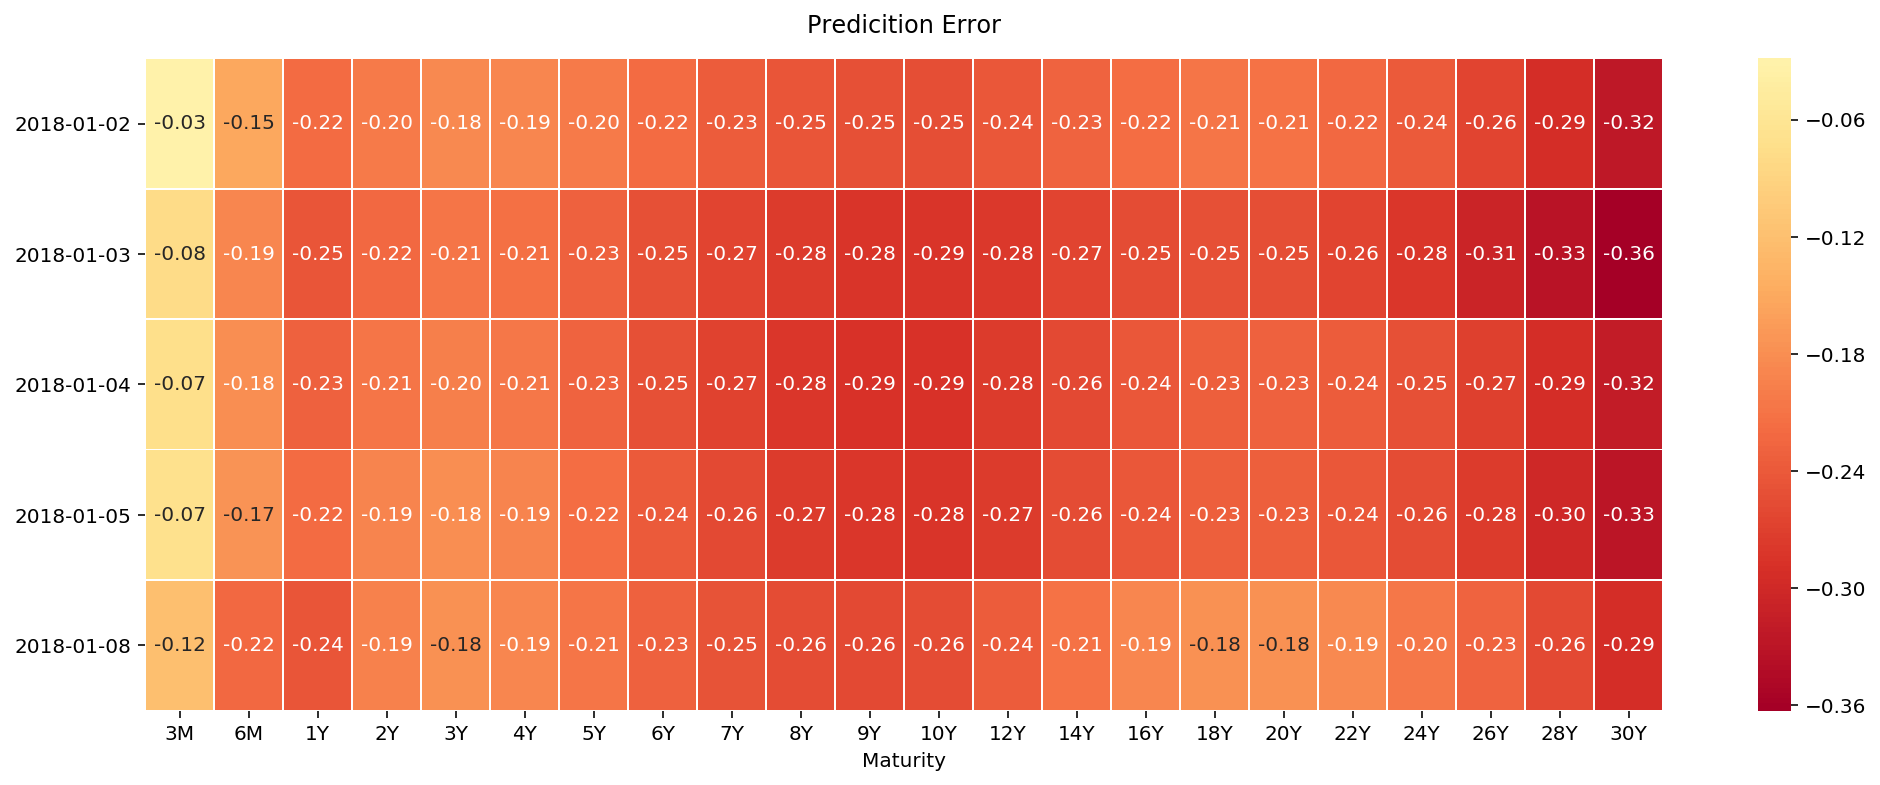

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (17,6))

plt.title("Predicition Error", fontsize = 12)
ttl = ax.title
ttl.set_position([0.5,1.02])

sns.heatmap(error_act, 
            fmt=".2f", 
            cmap = "RdYlGn", 
            linewidth = 0.3, 
            annot = True,
            center = 0)

plt.yticks(rotation=0)
plt.xlabel("Maturity")
plt.show()

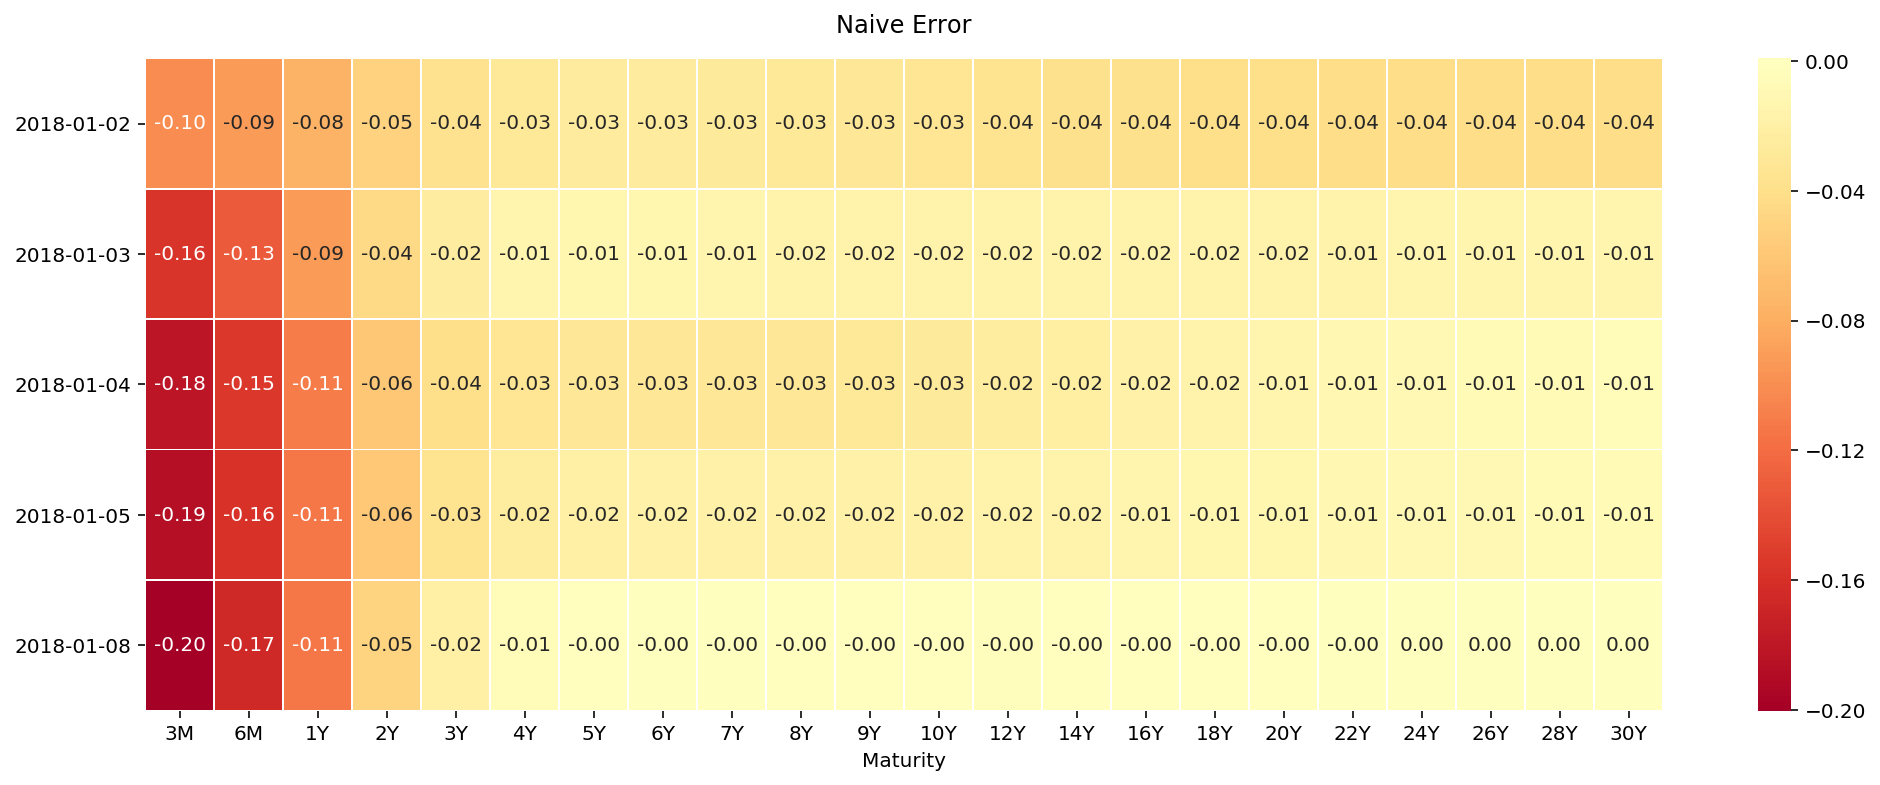

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (17,6))

plt.title("Naive Error", fontsize = 12)
ttl = ax.title
ttl.set_position([0.5,1.02])

sns.heatmap(error_naive, 
            fmt=".2f", 
            cmap = "RdYlGn", 
            linewidth = 0.3, 
            annot = True,
            center = 0)

plt.yticks(rotation=0)
plt.xlabel("Maturity")
plt.show()

### Visualization
***

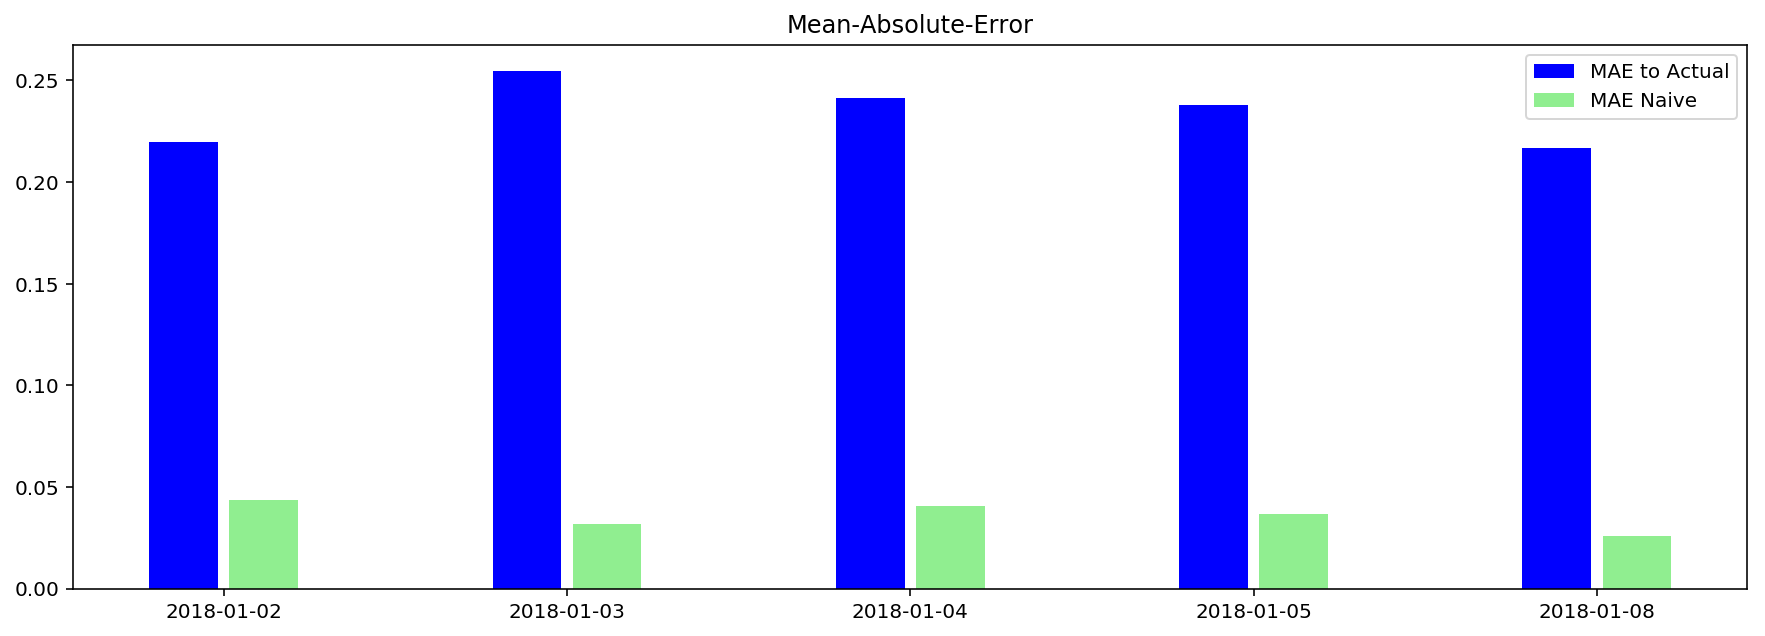

In [35]:
# Helper variables ----------------------------------------------------------
indx = np.arange(err.shape[0])
bar_width = 0.2


# Chart ---------------------------------------------------------------------
fig, ax = plt.subplots(1,1, figsize = [15,5])

ax.bar(indx - 0.05 - bar_width/3, err["mae_act"], bar_width, color = "blue", label = "MAE to Actual")
ax.bar(indx + 0.05 + bar_width/3, err["mae_naive"], bar_width, color = "lightgreen", label = "MAE Naive")

ax.set_title("Mean-Absolute-Error")
ax.set_xticks(indx)
ax.set_xticklabels(err.index.date)
ax.legend()

plt.show()

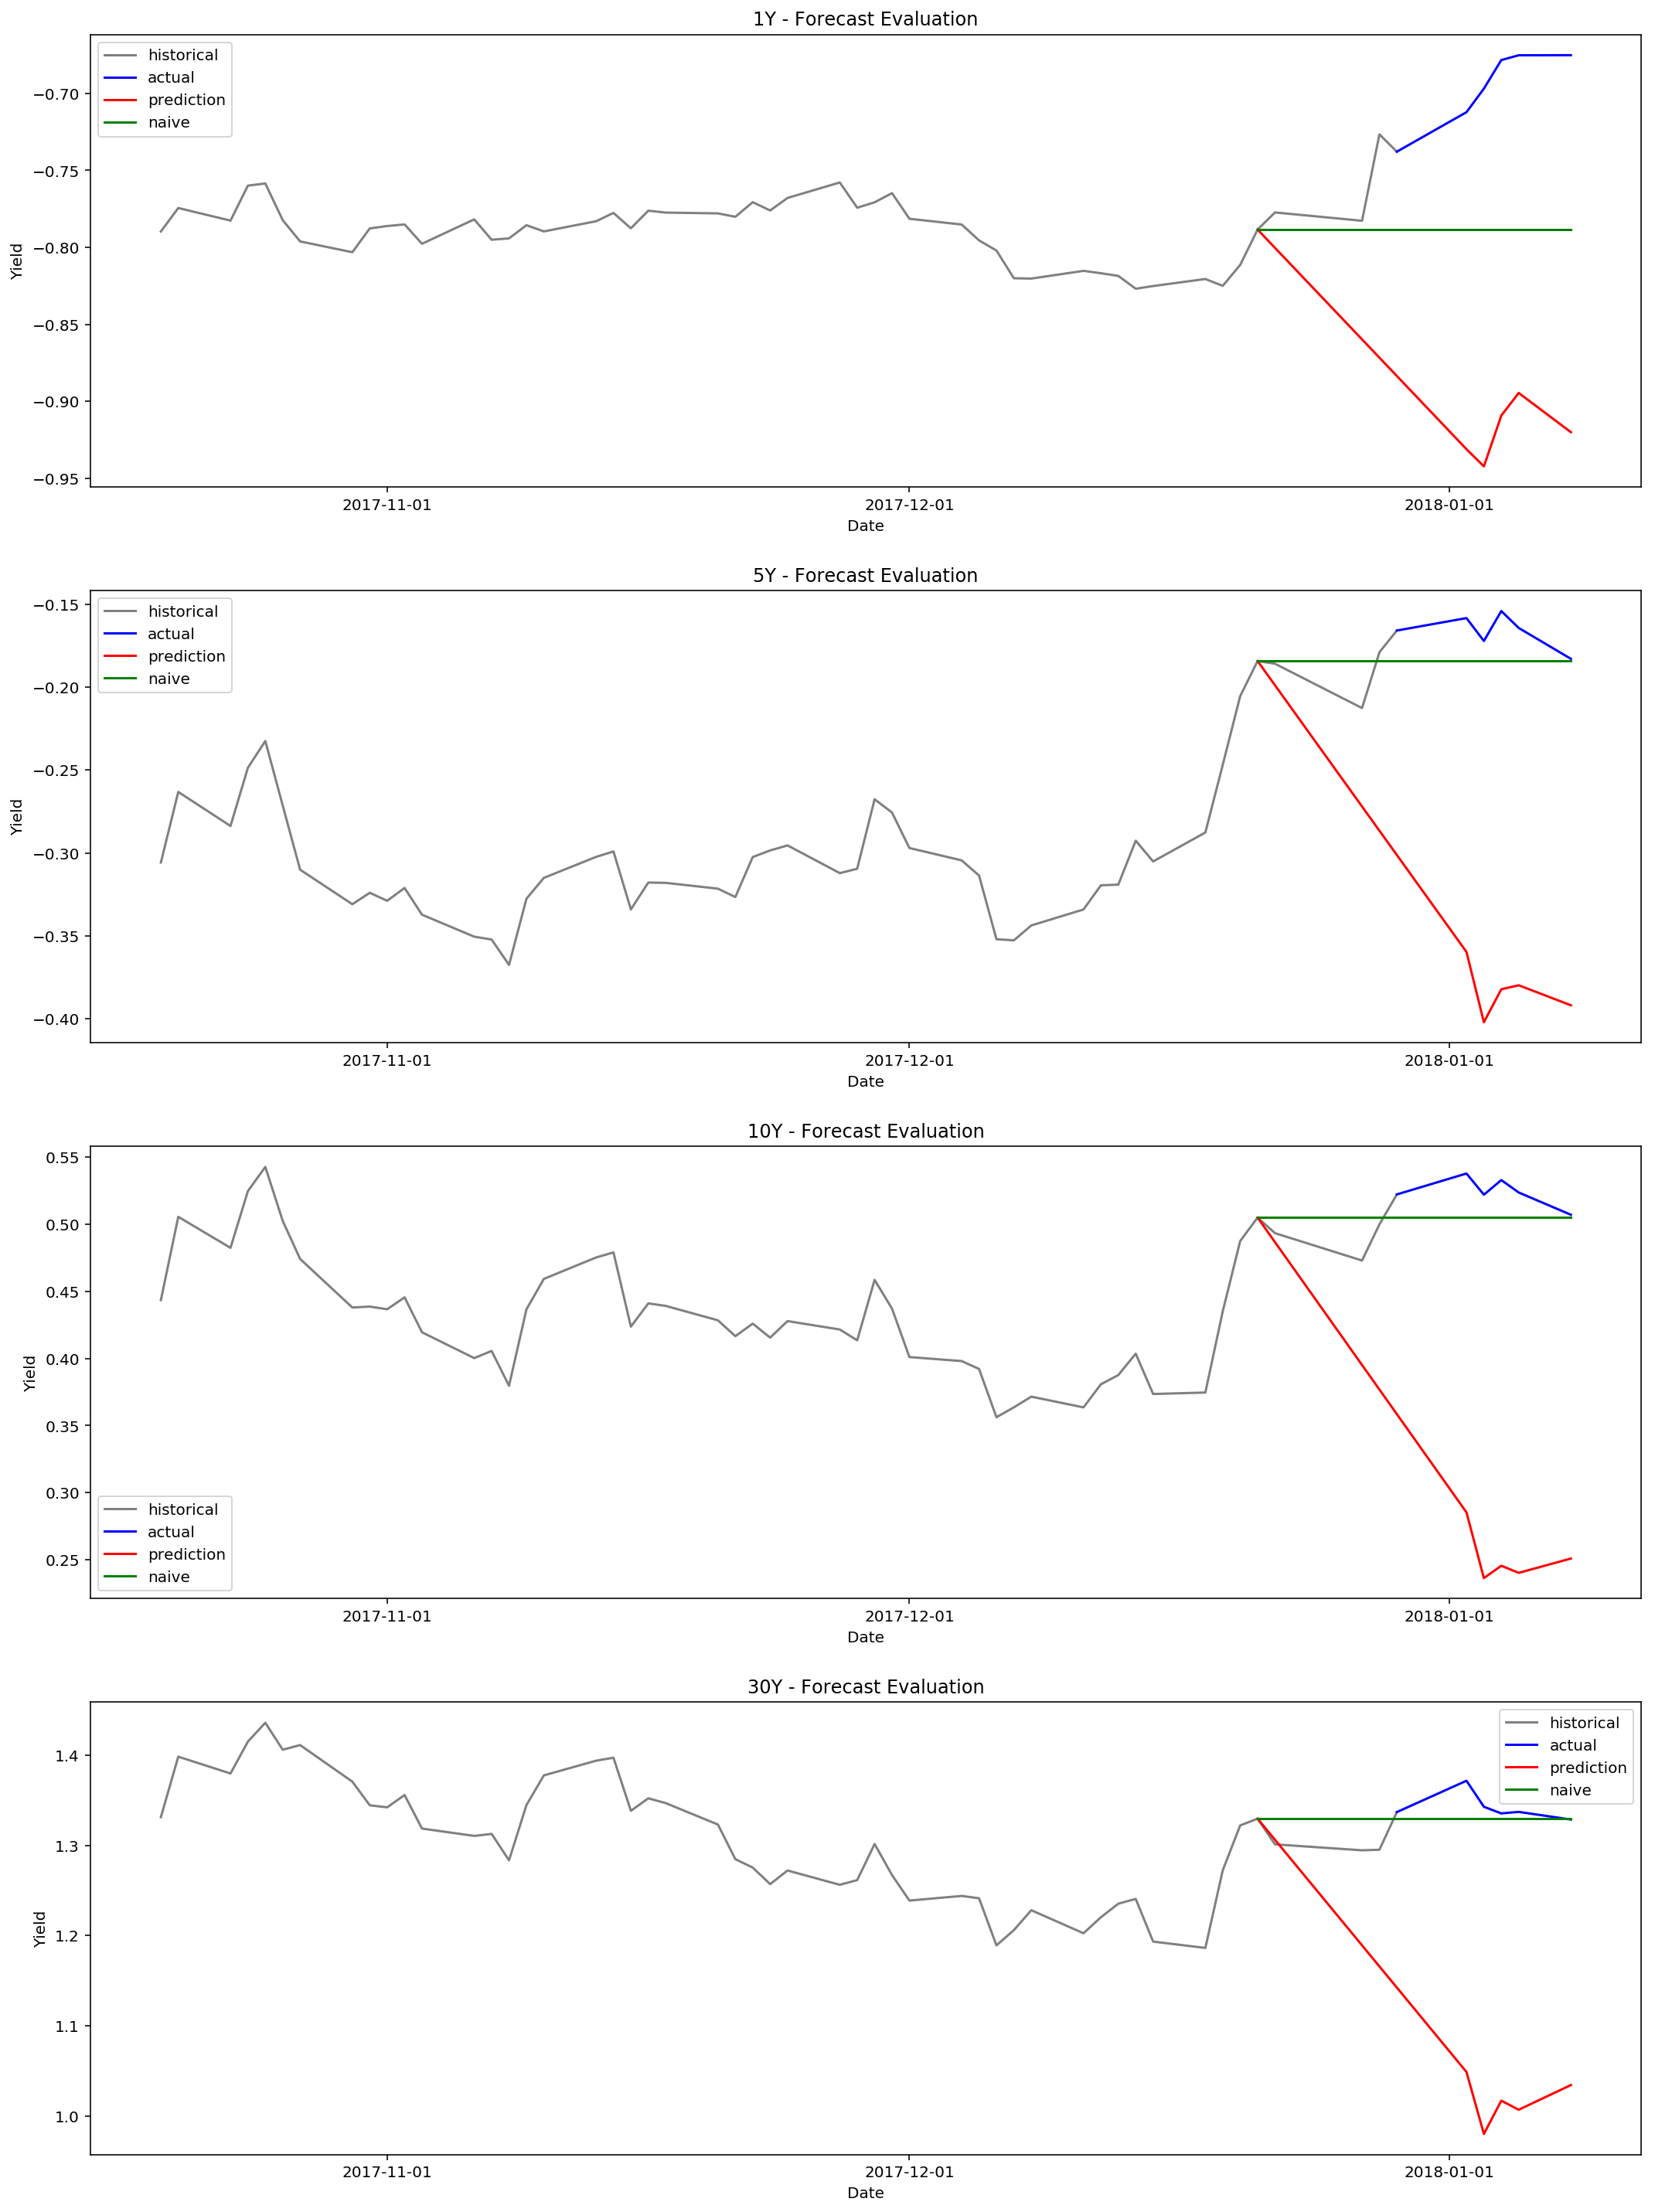

In [36]:
# Visual settings ---------------------------------------------------------
maturities = ["1Y","5Y","10Y","30Y"]
days_hist = 50

fig, ax = plt.subplots(len(maturities), 1, figsize = (15,5*len(maturities)))

# Data for chart ----------------------------------------------------------
chart_hist = spot_train.iloc[-days_hist:,:]
chart_act  = pd.concat([spot_train.iloc[-1:],spot_test.iloc[:steps]], axis = 0)
chart_naive = pd.concat([spot_train.iloc[-steps:-steps+1],naive], axis = 0)
chart_pred = pd.concat([spot_train.iloc[-steps:-steps+1],pred_spot], axis = 0)

# Chart -------------------------------------------------------------------
for i,j in enumerate(maturities):
    ax[i].plot (chart_hist[j], c="grey", label = "historical")
    ax[i].plot (chart_act[j], c="blue", label = "actual")
    ax[i].plot (chart_pred[j], c="red", label = "prediction")
    ax[i].plot (chart_naive[j], c="green", label = "naive")

    ax[i].set_title (j+" - Forecast Evaluation")
    ax[i].set_xlabel ("Date")
    ax[i].set_ylabel ("Yield")

    ax[i].xaxis.set_major_formatter(days_fmt)
    ax[i].xaxis.set_major_locator(months)
    ax[i].legend()


plt.tight_layout(h_pad=2.0)
plt.show()